# Calculating the rate as a function of track length

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm
import swordfish as sf
from WIMpy import DMUtils as DMU

# rc('text', usetex=True)
# rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
# rc('font',**{'family':'serif','serif':['cmr']})
%matplotlib inline

To try match 1806.05991 we are going to consider the Halite material (since this is what they present). Halite is made of NaCl but we dont know the Cl form factor now so we use Na23 as a starting point.

In [70]:
E_list = np.logspace(-1, 3, 30) # keV
# m_x = 500.0 #GeV

def calcdRdE(ER_keV, m_x, cp, cn, **kwargs):
    #Load in the list of nuclear spins, atomic masses and mass fractions
    nuclei_Halite = ["Na23"]
    frac_list_Halite = [1.0]
    frac_vals = dict(zip(nuclei_Halite, frac_list_Halite))

    dRdE = np.zeros_like(ER_keV)
    for nuc in nuclei_Halite:
        dRdE += frac_vals[nuc]*DMU.dRdE_NREFT(ER_keV, m_x, cp, cn, nuc, **kwargs)
    return dRdE

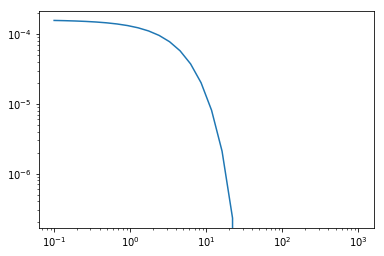

In [71]:
cp = np.zeros(11)
cp[0] = 1e-8
cn = cp

dRdE = calcdRdE(E_list, 10, cp, cn)
plt.loglog(E_list, dRdE)
plt.show()

We have the recoil rate, as a function of recoil energy but the observable is actually the recoils as a function of track length. The translation is done using 

$$ x_t(E_R) = \int_0^{E_R} dE \left(\frac{dE}{dx_t}(E)\right)^{-1}$$

where $\frac{dE}{dx_t}$ is given by [this paper](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.15.2458),

$$ \frac{dE}{dx_t} = N \int_0^{T_m} T \sigma(T) dT$$

where $T_m = \gamma E$, $\gamma=\frac{4 M_1 M_2}{(M_1+M_2)^2}$, $\sigma(T) = \sigma(\theta)\frac{4 \pi}{\gamma E}$, $N$ is the atomic density of the target, $M_1$ is the mass of the stopping nuclei, and $M_2$ is the mass of the target nuclei i.e. 23 GeV for Na23. $T = \gamma E\sin^2(\theta/2) $ and, finally, 

$$\theta = \pi - 2\int^\inf_{r_0} \frac{p dr}{r^2\left[1-V(r)/E_c-p^2/r^2\right]^{1/2}}$$

We also need $\sigma(\theta) = \frac{-p}{\sin\theta}\frac{dp}{d\theta}$, $E_c=\frac{E M_1}{(M_1+M_2)}$, $r_0$ is given by the root of $1-V(r)/E_c-p^2/r^2$. I'll start by considering a sodium nucleus being stopped in the potential of another sodium nucleus

In [72]:
from scipy.integrate import quad
from scipy import optimize
# p is the impact parameter in nanometres
M_Na = 23.*1.e6 # keV
m_DM = 500.*1.e6 # keV
ZNa = 11
e = 0.303 # No units
INVnm_to_keV = 0.197326979 # change inverse nanometres to keV (1 nm^-1 * hbar * c to keV)
V = lambda r: (ZNa**2.*e**2./r)*np.exp(-r/1.)*INVnm_to_keV # Add conversion factor to get V in keV

def calc_theta(p, E):
    """
    This corresponds to equation 4 of the paper. We calculate theta
    for a given impact parameter and energy input
    """
    Ec = M_Na*E/(2*M_Na)
    root = lambda r: 1-V(r)/Ec-p**2/r**2
    r0temp = optimize.brentq(root, 0.001, 100000)
    r0 = r0temp + 0.01*r0temp # for the numerics of the integral this
    # needs to be slightly higher than the root
    
    integrand = lambda r: p/r**2./(1-V(r)/Ec-p**2/r**2)**0.5
    I = quad(integrand,r0,np.inf)[0]
    return np.pi - 2.*I

def calc_dpdtheta(p, E):
    """
    This corresponds to second part of equation 5 of the paper.
    We simply find the derivative of theta with respect to p and
    take the inverse to get dp/dtheta
    """
    Ec = M_Na*E/(2*M_Na)
    root = lambda r: 1-V(r)/Ec-p**2/r**2
    r0temp = optimize.brentq(root, 0.001, 100000)
    r0 = r0temp + 0.01*r0temp # for the numerics of the integral this 
    # needs to be slightly higher than the root
    
    dp = np.array([p-p*0.01,p,p+p*0.01])
    pdiv = np.zeros_like(dp)
    for i, ptemp in enumerate(dp):
        integrand = lambda r: ptemp/r**2./(1-V(r)/Ec-ptemp**2/r**2)**0.5
        pdiv[i] = -2*quad(integrand,r0,np.inf)[0]
    
    dpdtheta = np.gradient(pdiv)[1]
    return 1./dpdtheta

def calc_sigmaT(T, E, p):
    """
    This corresponds to one of the terms in the integrand of equation 7 of the paper.
    """
    gamma = 4.*M_Na**2./((2*M_Na)**2.)
    theta = calc_theta(p, E)
    sigma_theta = -p*calc_dpdtheta(p, E)/np.sin(theta)
    return 4.*np.pi*sigma_theta/gamma/E

def calc_dEdx(E, p):
    """
    This corresponds to equation 7 of the paper.
    """
    N = 25.40902838311586 # N nm^-3 Number of sodium atoms per nano meter cubed
    gamma = 4.*M_Na**2./((2.*M_Na)**2.)
    Tm = gamma*E
    inte = lambda T: T*calc_sigmaT(T, E, p)
    return N*quad(inte, 0., Tm)[0]

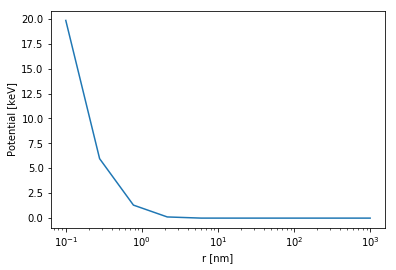

[-65.68314578 -14.41775959  -2.0612099    0.70581047   0.99066117
   0.99902917   0.99987461   0.99998381   0.99999791   0.99999973]


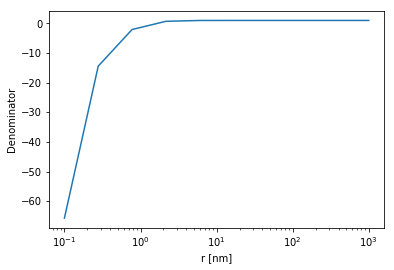

In [73]:
Ec = M_Na*1./(2*M_Na)
root = lambda r: 1-V(r)/Ec-p**2/r**2
rtest = np.logspace(-1,3,10)
plt.semilogx(rtest,V(rtest))
plt.ylabel("Potential [keV]")
plt.xlabel("r [nm]")
plt.show()

print(root(rtest))
plt.semilogx(rtest,root(rtest))
plt.ylabel("Denominator")
plt.xlabel("r [nm]")
plt.show()

In [74]:
cp = np.zeros(11)
cp[0] = 1e-6
cn = cp
m_dm = 500e6 # keV i.e. 10 GeV
p = 1/(25.**(1./3.)-1) # Impact parameter in nm

################ Calculting the rate
dRdE = calcdRdE(E_list, m_dm, cp, cn)
dEdx = np.zeros_like(E_list)
for i,E in enumerate(E_list):
    dEdx[i] = calc_dEdx(E, p)

dRdx = dRdE*dEdx

################ Calculting the track lengths
xlist = np.zeros_like(E_list)
temp = lambda E: calc_dEdx(E, p)**-1
for i,E in enumerate(E_list):
    print(i)
    xlist[i] = quad(temp,0.,E)[0]

0


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [78]:
print(xlist, E_list)

[6.85602913e-05 7.76931447e-05 8.87147691e-05 1.02319828e-04
 1.20171921e-04 1.42919052e-04 1.73524950e-04 2.14774285e-04
 2.71595404e-04 3.50290480e-04 4.57835407e-04 6.01174312e-04
 7.83180771e-04 1.00098974e-03 1.24541568e-03 1.50412675e-03
 1.76611682e-03 2.02458217e-03 2.27461971e-03 2.51503379e-03
 2.74651414e-03 2.97060807e-03 3.18862092e-03 3.40261968e-03
 3.61330860e-03 3.82192220e-03 4.02902362e-03 4.23637417e-03
 4.44293206e-03 4.64959771e-03] [1.00000000e-01 1.37382380e-01 1.88739182e-01 2.59294380e-01
 3.56224789e-01 4.89390092e-01 6.72335754e-01 9.23670857e-01
 1.26896100e+00 1.74332882e+00 2.39502662e+00 3.29034456e+00
 4.52035366e+00 6.21016942e+00 8.53167852e+00 1.17210230e+01
 1.61026203e+01 2.21221629e+01 3.03919538e+01 4.17531894e+01
 5.73615251e+01 7.88046282e+01 1.08263673e+02 1.48735211e+02
 2.04335972e+02 2.80721620e+02 3.85662042e+02 5.29831691e+02
 7.27895384e+02 1.00000000e+03]


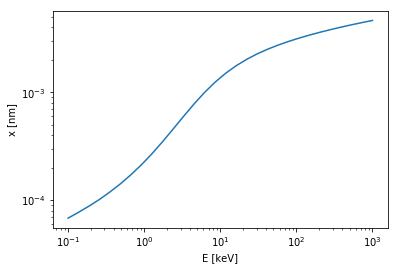

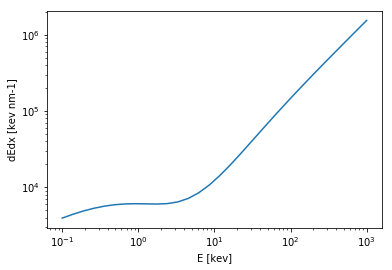

In [79]:
plt.loglog(E_list, xlist)
plt.xlabel("E [keV]")
plt.ylabel("x [nm]")
plt.show()
plt.loglog(E_list, dEdx)
plt.xlabel("E [kev]")
plt.ylabel("dEdx [kev nm-1]")
plt.show()

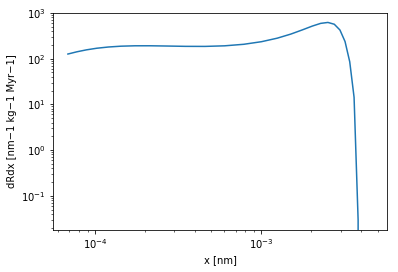

In [80]:
dRdx = dRdE*dEdx
plt.loglog(xlist, dRdx*1e6) # 1e6 here to change to per Myr
plt.ylabel(r"dRdx [nm−1 kg−1 Myr−1]")
plt.xlabel(r"x [nm]")
plt.show()